In [93]:
#Data Exploration

In [94]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

In [95]:
# Load csv file
df = pd.read_csv('/Users/priyadhage/Desktop/BestBuy-reviews_file.csv')
df.head(10)

,Brand Name,Product Name,Review Votes,Rating,Reviews
0,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,"This keyboard is very easy to type on, but the..."
1,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,It's thin and light. I can type pretty easily ...
2,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,I love the new design the keys are spaced well...
3,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,Attached easily and firmly. Has a nice feel. A...
4,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,"Our original keyboard was okay, but did not ha..."
5,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,purchased to replace original surface pro 3 ke...
6,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,I find it very comfortable to type with it but...
7,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,3,Good Keyboard and addition to the Surface Pro ...
8,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,"tough getting it to work on surface pro 3, but..."
9,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,I can now quickly and hassle free log into my ...


In [96]:
# Data Exploration
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))

Summary statistics of numerical features : 
        Review Votes       Rating
count   5814.000000  5814.000000
mean       0.746646     4.480392
std        3.419966     0.903123
min        0.000000     1.000000
25%        0.000000     4.000000
50%        0.000000     5.000000
75%        0.000000     5.000000
max      128.000000     5.000000

Total number of reviews:  5814

Total number of brands:  38

Total number of unique products:  50

Percentage of reviews with neutral sentiment : 5.07%

Percentage of reviews with positive sentiment : 89.99%

Percentage of reviews with negative sentiment : 4.94%


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Rating')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

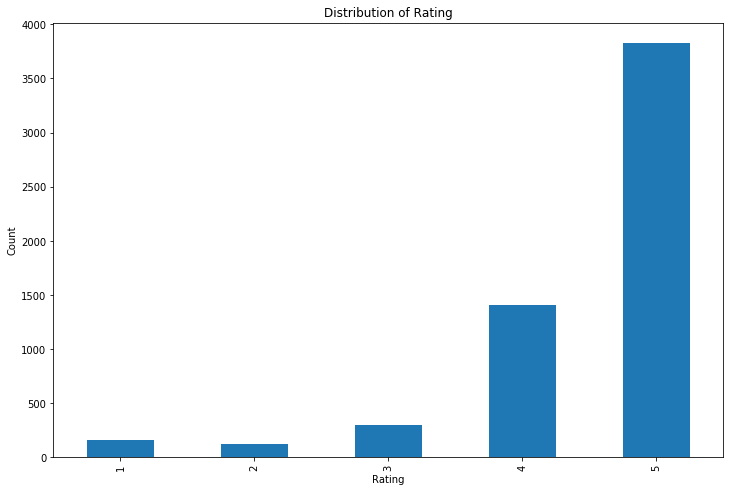

In [97]:
# Data Visualization
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

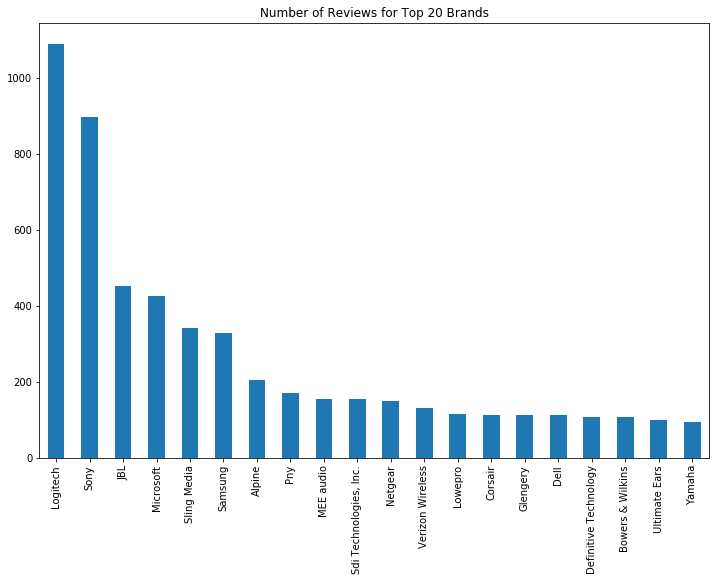

In [98]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

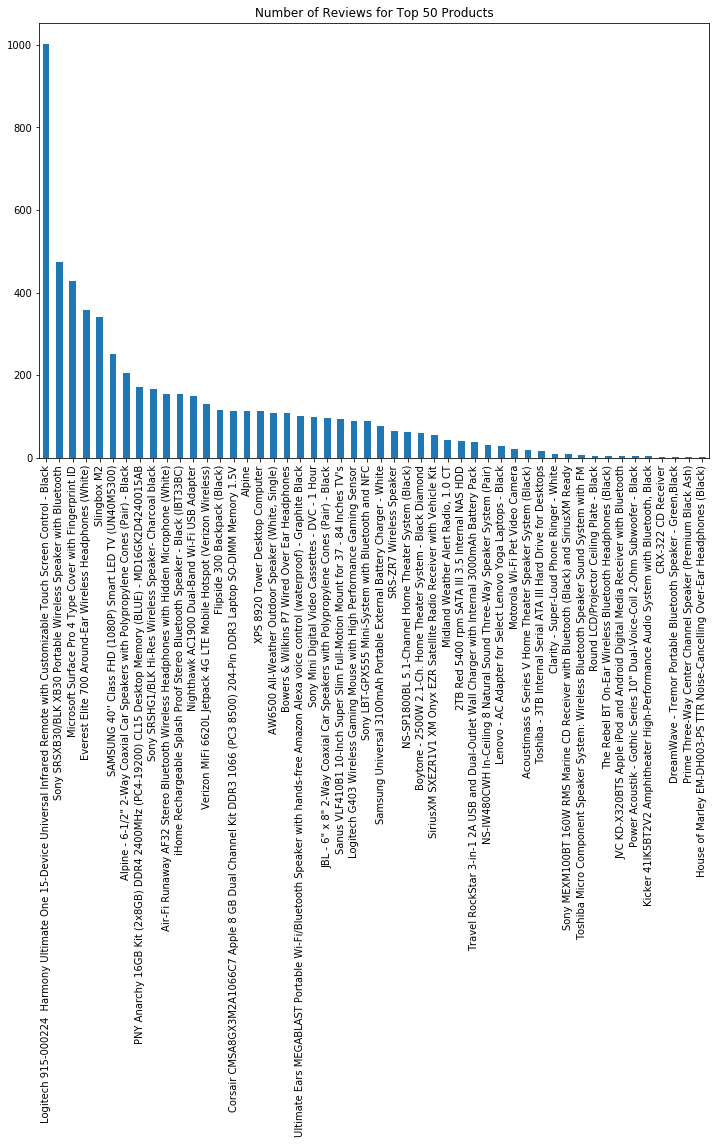

In [99]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Review Length')

Text(0.5, 0, 'Review length (Number of character)')

Text(0, 0.5, 'Count')

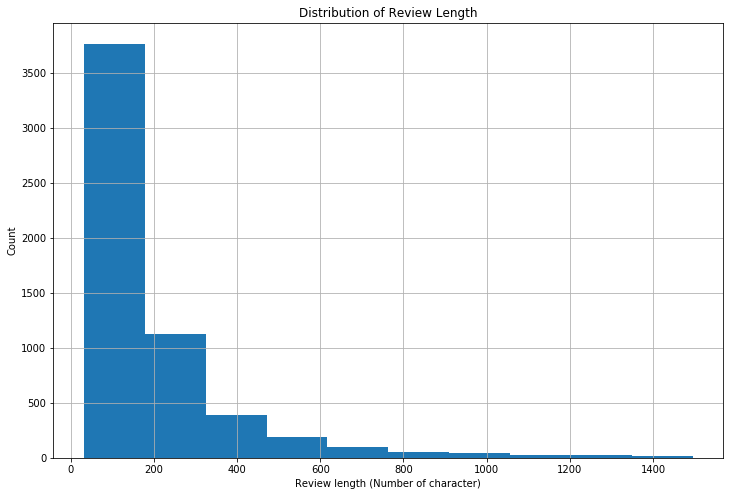

In [100]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [101]:
# To simplify the problem, we only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3).
# Part 2. Data Preparation
# Prepare Data


# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(95)

,Brand Name,Product Name,Review Votes,Rating,Reviews,Sentiment
0,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,"This keyboard is very easy to type on, but the...",1
1,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,It's thin and light. I can type pretty easily ...,1
2,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,I love the new design the keys are spaced well...,1
3,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,Attached easily and firmly. Has a nice feel. A...,1
4,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,"Our original keyboard was okay, but did not ha...",1
...,...,...,...,...,...,...
94,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,"I use my Surface Pro 4 mostly in tablet mode, ...",1
95,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,1,Don't waste your money on the finger print ID ...,0
96,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,4,The keyboard is great and there's more space t...,1
97,Microsoft,Microsoft Surface Pro 4 Type Cover with Finger...,0,5,The finger print scanner works great and is qu...,1


In [102]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 4967 training examples and 552 validation examples. 

Show a review in the training set : 
 Excellent functionality...fully cable with little or no performance issues as long as you have high speed internet at both end of transmission


In [103]:
# Part 3.
# classify the reviews into positive and negative sentiment. There are two main steps involved. 
# First, we need to find a word embedding to convert a text into a numerical representation.
# Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.
# Text Preprocessing
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [104]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 excellent functionality fully cable with little or no performance issues as long as you have high speed internet at both end of transmission


In [105]:
# CountVectorizer with Multinomial Naive Bayes (Benchmark Model)
# Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.
#In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. 
#The output is a sparse matrix representation of a document.
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 7935 

Show some feature names : 
 ['aa', 'capabilites', 'disturbing', 'grad', 'lit', 'perception', 'rwith', 'tell']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [106]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [107]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9457

AUC score : 0.5946

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.19      0.32        37
           1       0.94      1.00      0.97       515

    accuracy                           0.95       552
   macro avg       0.97      0.59      0.64       552
weighted avg       0.95      0.95      0.93       552


Confusion Matrix : 
 [[  7  30]
 [  0 515]]


In [108]:
#TfidfVectorizer with Logistic Regression
# Some words might frequently appear but have little meaningful information about the sentiment of a particular review.

tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 2554 

Show some feature names : 
 ['00', 'hated', 'showing']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'returned' 'back' 'work' 'return' 'get' 'did' 'when' 'didn' 'it']

Top 10 features with largest coefficients : 
['great' 'easy' 'love' 'good' 'works' 'nice' 'my' 'well' 'recommend'
 'perfect']


In [110]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9330

AUC score : 0.5000

Classification report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.93      1.00      0.97       515

    accuracy                           0.93       552
   macro avg       0.47      0.50      0.48       552
weighted avg       0.87      0.93      0.90       552


Confusion Matrix : 
 [[  0  37]
 [  0 515]]


In [111]:
# GridSearch
#In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                    

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9438

AUC score : 0.6563

Classification report : 
               precision    recall  f1-score   support

           0       0.67      0.32      0.44        37
           1       0.95      0.99      0.97       515

    accuracy                           0.94       552
   macro avg       0.81      0.66      0.70       552
weighted avg       0.93      0.94      0.93       552


Confusion Matrix : 
 [[ 12  25]
 [  6 509]]


In [112]:
#Part 4. Word2Vec
#Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. 
# Both are shallow neural networks which learn weights for word vector representations.
#Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
#Step 2 : Create volcabulary list using Word2Vec model
#Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
#Step 4 : Fit the average feature vectors to Random Forest Classifier


In [113]:
# Parsing Review into Sentences
# Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. 
# Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.
# Fit parsed sentences to Word2Vec model 


# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

4967 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['excellent', 'functionality', 'fully', 'cable', 'with', 'little', 'or', 'no', 'performance', 'issues', 'as', 'long', 'as', 'you', 'have', 'high', 'speed', 'internet', 'at', 'both', 'end', 'of', 'transmission']


In [114]:
# Creating Volcabulary List using Word2Vec Model
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 100  #embedding dimension                     
min_word_count = 15                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 1276 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['the', 'and', 'to', 'i', 'a', 'it', 'is', 'for', 'this', 'my']


In [115]:
#Averaging Feature Vectors
#Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 100).
#To find a numerical representation for a review, we run through each word in a review text. 
#For words appear in the volcabulary list, we compute the average feature vectors of all those words. 
#The average feature vector is the numerical represenation of the review.


In [116]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [117]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

Training set : 4967 feature vectors with 100 dimensions
Validation set : 552 feature vectors with 100 dimensions


In [118]:
#Random Forest Classifer
# We can now train Random Forest Classifier using feature vectors of reviews in the training set.
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Accuracy on validation set: 0.9348

AUC score : 0.5135

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.03      0.05        37
           1       0.93      1.00      0.97       515

    accuracy                           0.93       552
   macro avg       0.97      0.51      0.51       552
weighted avg       0.94      0.93      0.90       552


Confusion Matrix : 
 [[  1  36]
 [  0 515]]


In [119]:
#Part 5. LSTM
#Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.
#In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative sentiment using Keras libarary.
# Simple LSTM

top_words = 5000 
maxlen = 50 
batch_size = 16
nb_classes = 2
nb_epoch = 4


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)


X_train shape: (4967, 50)
X_test shape: (552, 50)
y_train shape: (4967, 2)
y_test shape: (552, 2)


In [120]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 64, dropout=0.2))
model1.add(LSTM(32, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 332,482
Trainable params: 332,482
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
4967/4967 [==============================] - 8s 2ms/step - loss: 0.2283 - accuracy: 0.9468
Epoch 2/4
4967/4967 [==============================] - 7s 1ms/step - loss: 0.1381 - accuracy: 0.9517
Epoch 3/4
4967/4967 [=======================

552/552 [==============================] - 0s 469us/step
Test loss : 0.3051
Test accuracy : 0.9293


In [121]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(5000, 64)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(64, 128)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(32, 2) weight dim of dense layer

array([[ 0.03093424,  0.00997639, -0.01502572, ..., -0.00484152,
        -0.03120896, -0.00678278],
       [ 0.00053364,  0.08134696, -0.05340759, ...,  0.05396474,
         0.01872513,  0.00193443],
       [-0.02269629,  0.02499555,  0.02578609, ...,  0.06821644,
        -0.02496137,  0.03707117],
       ...,
       [-0.00585858, -0.03508549,  0.0035333 , ...,  0.04419895,
        -0.01986755,  0.02750241],
       [ 0.05564157, -0.0607947 , -0.09138378, ..., -0.00071869,
        -0.05885169,  0.04764256],
       [ 0.01751739, -0.02370163,  0.00743768, ..., -0.03204014,
        -0.0282572 , -0.01439674]], dtype=float32)

Size of weight matrix in the embedding layer :  (5000, 64)
Size of weight matrix in the hidden layer :  (64, 128)
Size of weight matrix in the output layer :  (32, 2)


In [122]:
#LSTM with Word2Vec Embedding
#In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account. 
#The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.
#Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. 
#In this part, we use the Word2Vec embedding trained in Part 4 to intialize the weights of embedding layer in LSTM.

In [123]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (1276, 100)


In [124]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 50 
batch_size = 16
nb_classes = 2
nb_epoch = 4


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (4967, 50)
X_test shape: (552, 50)
y_train shape: (4967, 2)
y_test shape: (552, 2)


In [125]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #100
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(32, dropout_W=0.2, dropout_U=0.1)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         127600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_4 (Activation)    (None, 2)                 0         
Total params: 144,690
Trainable params: 144,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
4967/4967 [==============================] - 8s 2ms/step - loss: 0.2112 - accuracy: 0.9475
Epoch 2/4
4967/4967 [==============================] - 7s 1ms/step - loss: 0.1634 - accuracy: 0.9503
Epoch 3/4
4967/4967 [=======================

552/552 [==============================] - 0s 474us/step
Test loss : 0.2340
Test accuracy : 0.9312


In [126]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (1276, 100)
Size of weight matrix in the hidden layer :  (100, 128)
Size of weight matrix in the output layer :  (32, 2)


In [127]:
#Part 6. Word Cloud
#In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.
def create_word_cloud(brand, sentiment):
    try: 
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''
        
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]
            
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]
            
        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except: 
        pass

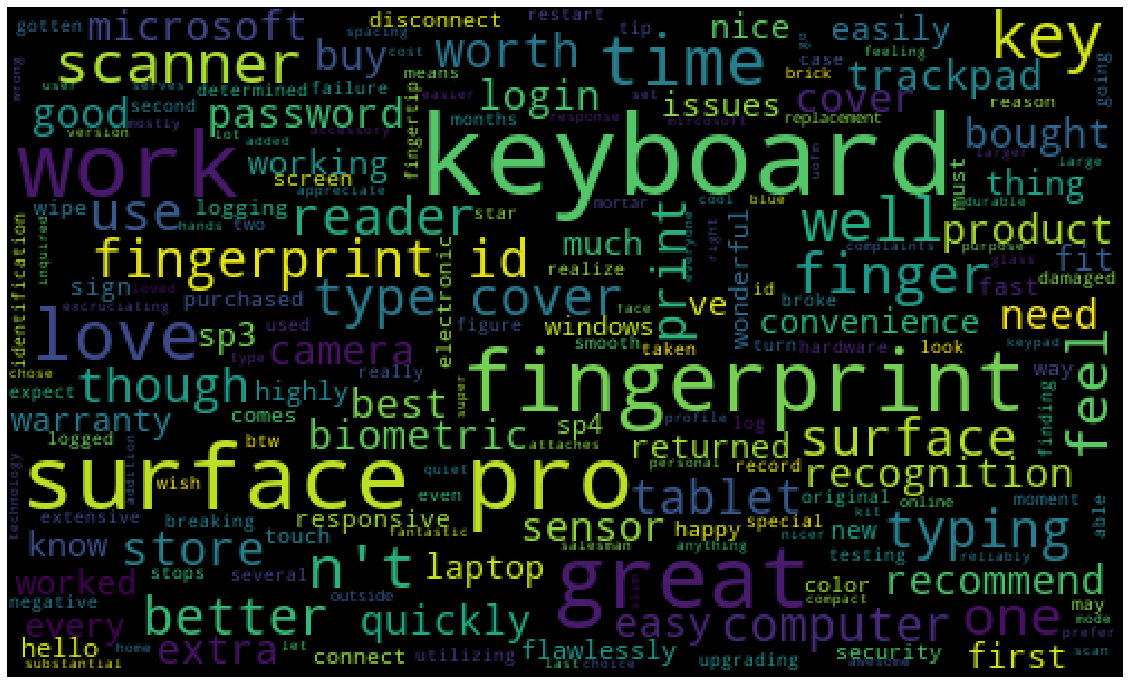

In [128]:
create_word_cloud(brand='Microsoft', sentiment=1)

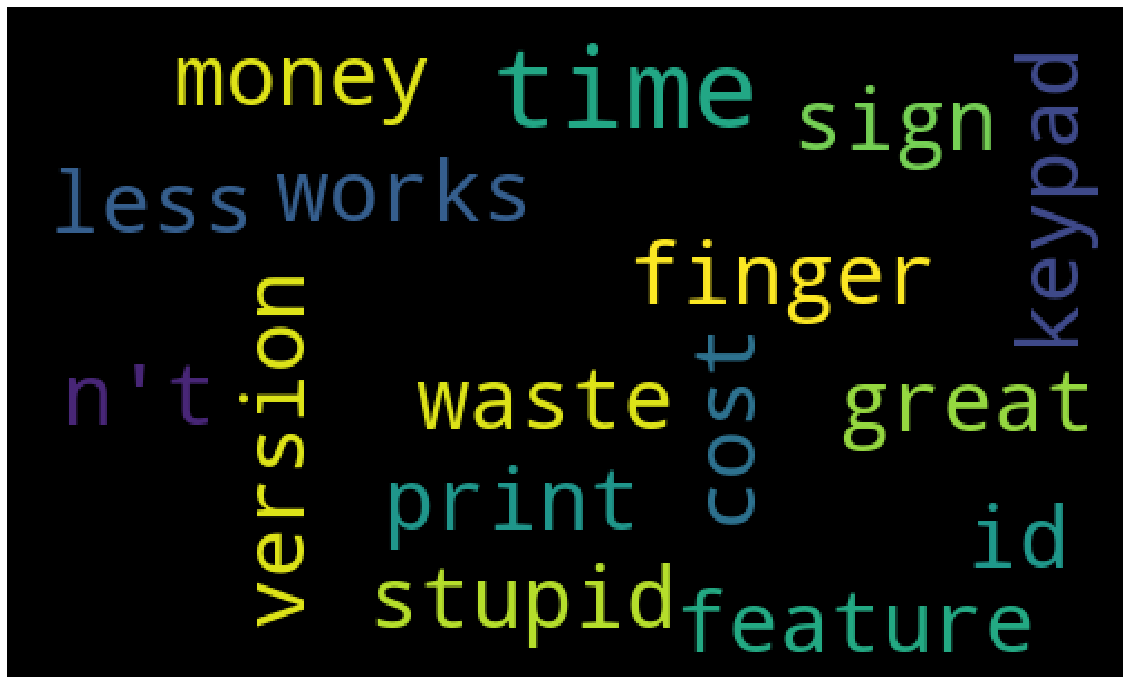

In [129]:
create_word_cloud(brand='Microsoft', sentiment=0)


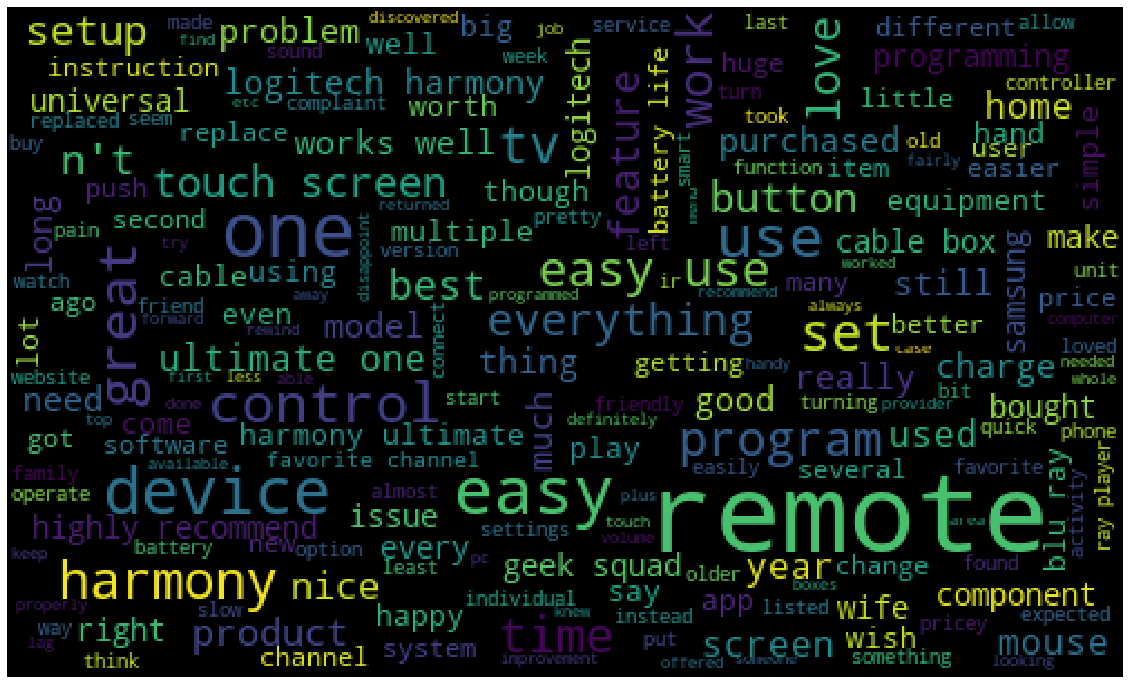

In [130]:
create_word_cloud(brand='Logitech', sentiment=1)

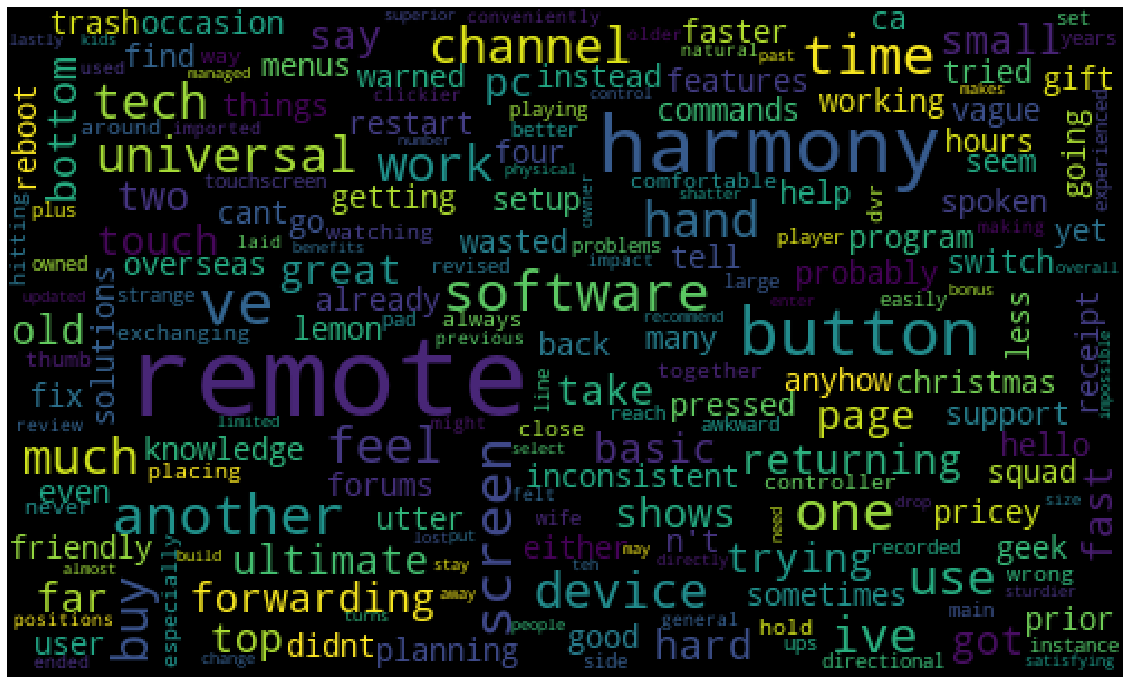

In [131]:
create_word_cloud(brand='Logitech', sentiment=0)

In [132]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [133]:
# Import the dataset and give the column names
columns=['userId', 'productId','timestamp', 'ratings']
electronics_df=pd.read_csv('/Users/priyadhage/Desktop/BestBuy-reviews_file1.csv',names=columns)

In [134]:
electronics_df.head(10)

,userId,productId,timestamp,ratings
0,JNH1,B0168YIWSI,2015-12-04T00:00:00.000Z,5.0
1,Appa,B0168YIWSI,2015-12-04T00:00:00.000Z,4.0
2,Kman,B0168YIWSI,2015-12-04T00:00:00.000Z,4.0
3,UpstateNY,B0168YIWSI,2015-12-01T00:00:00.000Z,5.0
4,Glickster,B0168YIWSI,2015-11-28T00:00:00.000Z,5.0
5,gjohnsonxc,B0168YIWSI,2015-11-28T00:00:00.000Z,5.0
6,nakulrk,B0168YIWSI,2015-11-27T00:00:00.000Z,4.0
7,Angie,B0168YIWSI,2015-11-27T00:00:00.000Z,3.0
8,papabear,B0168YIWSI,2016-02-05T00:00:00.000Z,4.0
9,A199578,B0168YIWSI,2016-02-05T00:00:00.000Z,5.0


In [135]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [136]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7299 entries, 0 to 7298
Data columns (total 3 columns):
userId       7299 non-null object
productId    7299 non-null object
ratings      7135 non-null float64
dtypes: float64(1), object(2)
memory usage: 171.2+ KB


In [137]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7299
Number of columns:  3


In [138]:
#Check the datatypes
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [139]:
# the dataset
electronics_df1=electronics_df.iloc[:7000,0:]

In [140]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 3 columns):
userId       7000 non-null object
productId    7000 non-null object
ratings      6836 non-null float64
dtypes: float64(1), object(2)
memory usage: 164.2+ KB


In [141]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    6836.000000
mean        4.376975
std         1.036534
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: ratings, dtype: float64

In [142]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [143]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId         0
productId      0
ratings      164
dtype: int64


In [144]:
electronics_df1['ratings'].dropna(axis=0, how='any', inplace=False)

0       5.0
1       4.0
2       4.0
3       5.0
4       5.0
       ... 
6995    5.0
6996    5.0
6997    5.0
6998    1.0
6999    5.0
Name: ratings, Length: 6836, dtype: float64

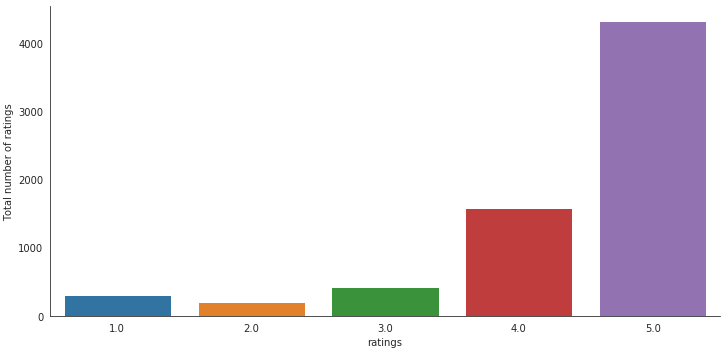

In [145]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [146]:
#Users and products
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  6248
Number of unique product in Raw data =  49


In [147]:
#3. Taking the subset of dataset to make it less sparse/ denser.
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
PAPP45       23
Mike         20
RES245       18
John         15
CHIN12       15
Anonymous    13
James        13
Chris        13
Jeff         12
Dave         10
dtype: int64


In [148]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 15 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 15 or more items = 91
Number of unique users in the final data =  5
Number of unique products in the final data =  5


In [149]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.reset_index().pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
userId,,,,,,,,,,,,,,,,,,,,,
CHIN12,0.0,0.0,0.0,0.0,0.0,0.0,3.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John,0.0,0.0,5.0,0.0,5.0,5.0,5.000000,0.0,0.0,4.0,...,0.0,0.0,0.0,5.0,4.0,4.5,0.0,3.0,5.0,0.0
Mike,5.0,5.0,5.0,5.0,0.0,0.0,4.428571,0.0,5.0,0.0,...,1.0,0.0,5.0,5.0,4.0,0.0,5.0,0.0,4.0,5.0
PAPP45,0.0,0.0,0.0,0.0,0.0,0.0,3.761905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RES245,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,0.0,0.0,...,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [150]:
#It shows that it is a sparse matrix. So, many cells are filled with 0 values.

In [151]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (5, 23)


In [152]:
#Calculating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  33
possible_num_of_ratings =  115
density: 28.70%


In [153]:
#The density value of the matrix also shows that it is a sparse matrix.

In [154]:
#4. Splitting the data
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
6528,Mike,B00IAKLM54,5.0
690,John,B00C78VIUE,5.0
5874,PAPP45,B00IAKLM54,5.0
6036,PAPP45,B00IAKLM54,3.0
3711,RES245,B01CEAT9ZU,1.0


In [155]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (63, 3)
Shape of testing data:  (28, 3)


In [156]:
#5. Building Popularity Recommder model
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B000YA33DC,1
1,B00505EZYW,1
2,B00C78VIUE,1
3,B00IAKLM54,32
4,B00IWQ3YPC,3
5,B012ASF1WQ,3
6,B0168YIWSI,2
7,B01CEAT9ZU,7
8,"B01J0BFAAO,B019Q88VAM",1
9,B01KUAMCWI,1


In [157]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
3,B00IAKLM54,32,1.0
7,B01CEAT9ZU,7,2.0
14,B071ZVQVFQ,5,3.0
4,B00IWQ3YPC,3,4.0
5,B012ASF1WQ,3,5.0


In [158]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [159]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

    userId   productId  score  rank
3       10  B00IAKLM54     32   1.0
7       10  B01CEAT9ZU      7   2.0
14      10  B071ZVQVFQ      5   3.0
4       10  B00IWQ3YPC      3   4.0
5       10  B012ASF1WQ      3   5.0


The list of recommendations for the userId: 100

    userId   productId  score  rank
3      100  B00IAKLM54     32   1.0
7      100  B01CEAT9ZU      7   2.0
14     100  B071ZVQVFQ      5   3.0
4      100  B00IWQ3YPC      3   4.0
5      100  B012ASF1WQ      3   5.0


The list of recommendations for the userId: 150

    userId   productId  score  rank
3      150  B00IAKLM54     32   1.0
7      150  B01CEAT9ZU      7   2.0
14     150  B071ZVQVFQ      5   3.0
4      150  B00IWQ3YPC      3   4.0
5      150  B012ASF1WQ      3   5.0




In [160]:
#Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. 
#Here, we predict the products based on the popularity. It is not personalized to particular user. 
#It is a non-personalized recommender system.

In [161]:
#6. Building Collaborative Filtering recommender model.
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,6528,Mike,B00IAKLM54,5.0
1,690,John,B00C78VIUE,5.0
2,5874,PAPP45,B00IAKLM54,5.0
3,6036,PAPP45,B00IAKLM54,3.0
4,3711,RES245,B01CEAT9ZU,1.0


In [162]:
#User Based Collaborative Filtering model
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot_table(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
userId,,,,,,,,,,,,,,,,,,,,,
CHIN12,0.0,0.0,0.0,0.0,0.0,0.0,3.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John,0.0,0.0,5.0,0.0,5.0,5.0,5.000000,0.0,0.0,4.0,...,0.0,0.0,0.0,5.0,4.0,4.5,0.0,3.0,5.0,0.0
Mike,5.0,5.0,5.0,5.0,0.0,0.0,4.428571,0.0,5.0,0.0,...,1.0,0.0,5.0,5.0,4.0,0.0,5.0,0.0,4.0,5.0
PAPP45,0.0,0.0,0.0,0.0,0.0,0.0,3.761905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RES245,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,0.0,0.0,...,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [163]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (5, 23)


In [164]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9,user_index
userId,,,,,,,,,,,,,,,,,,,,,
CHIN12,0.0,0.0,0.0,0.0,0.0,0.0,3.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
John,0.0,0.0,5.0,0.0,5.0,5.0,5.000000,0.0,0.0,4.0,...,0.0,0.0,5.0,4.0,4.5,0.0,3.0,5.0,0.0,1
Mike,5.0,5.0,5.0,5.0,0.0,0.0,4.428571,0.0,5.0,0.0,...,0.0,5.0,5.0,4.0,0.0,5.0,0.0,4.0,5.0,2
PAPP45,0.0,0.0,0.0,0.0,0.0,0.0,3.761905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
RES245,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,0.0,0.0,...,3.9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4


In [165]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,3.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,5.0,0.0,5.0,5.0,5.000000,0.0,0.0,4.0,...,0.0,0.0,0.0,5.0,4.0,4.5,0.0,3.0,5.0,0.0
2,5.0,5.0,5.0,5.0,0.0,0.0,4.428571,0.0,5.0,0.0,...,1.0,0.0,5.0,5.0,4.0,0.0,5.0,0.0,4.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,3.761905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,0.0,0.0,...,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [166]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 4)

In [167]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.43149122 -0.00380192  0.01359708 -0.07263502]
 [-0.18794084  0.09193128  0.66453105 -0.71701754]
 [-0.01091059  0.06216117 -0.73624443 -0.67271002]
 [ 0.88172916  0.05650899  0.12510256 -0.12162983]
 [ 0.03046667 -0.9922081   0.02251856 -0.11522765]]


In [168]:
print('Sigma: \n',sigma)

Sigma: 
 [ 6.08102481  7.85498508 13.27039047 20.04882002]


In [169]:
#As sigma is not a diagonal matrix we have to convert it into diagonal matrix.
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[ 6.08102481  0.          0.          0.        ]
 [ 0.          7.85498508  0.          0.        ]
 [ 0.          0.         13.27039047  0.        ]
 [ 0.          0.          0.         20.04882002]]


In [170]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-0.00897101 -0.00897101 -0.16350157 -0.00897101 -0.15453056 -0.15453056
   0.66709547  0.0250506  -0.00897101 -0.12362445  0.57045345 -0.15453056
  -0.15453056 -0.0017942   0.01953947 -0.00897101 -0.16350157 -0.13080126
  -0.13907751 -0.00897101 -0.09271834 -0.13665677 -0.00897101]
 [ 0.03956798  0.03956798  0.09808577  0.03956798  0.05851779  0.05851779
  -0.00759254 -0.6315786   0.03956798  0.04681423  0.09448793  0.05851779
   0.05851779  0.0079136  -0.49263131  0.03956798  0.09808577  0.07846861
   0.05266601  0.03956798  0.03511067 -0.54140643  0.03956798]
 [-0.27740119 -0.27740119 -0.02702007 -0.27740119  0.25038112  0.25038112
   0.0458742   0.00848451 -0.27740119  0.2003049   0.2975171   0.25038112
   0.25038112 -0.05548024  0.00661792 -0.27740119 -0.02702007 -0.02161606
   0.22534301 -0.27740119  0.15022867  0.03694468 -0.27740119]
 [-0.16776798 -0.16776798 -0.34658587 -0.16776798 -0.17881789 -0.17881789
  -0.37023213 -0.02873677 -0.16776798 -0.14305

In [171]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
0,0.169537,0.169537,0.067896,0.169537,-0.101640,-0.101640,2.298051,0.127971,0.169537,-0.081312,...,0.033907,0.099817,0.169537,0.067896,0.054317,-0.091476,0.169537,-0.060984,0.161960,0.169537
1,0.004264,0.004264,5.001707,0.004264,4.997444,4.997444,4.958876,0.003218,0.004264,3.997955,...,0.000853,0.002510,0.004264,5.001707,4.001366,4.497700,0.004264,2.998466,5.004073,0.004264
2,4.992888,4.992888,4.997152,4.992888,0.004264,0.004264,4.497166,-0.005368,4.992888,0.003411,...,0.998578,-0.004187,4.992888,4.997152,3.997722,0.003837,4.992888,0.002558,3.993206,4.992888
3,-0.081960,-0.081960,-0.032823,-0.081960,0.049136,0.049136,4.552456,-0.061865,-0.081960,0.039309,...,-0.016392,-0.048255,-0.081960,-0.032823,-0.026259,0.044223,-0.081960,0.029482,-0.078297,-0.081960
4,-0.005368,-0.005368,-0.002150,-0.005368,0.003218,0.003218,1.051777,4.995948,-0.005368,0.002575,...,-0.001074,3.896840,-0.005368,-0.002150,-0.001720,0.002896,-0.005368,0.001931,4.994872,-0.005368


In [172]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [173]:
userID = 2
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                                  user_ratings  user_predictions
Recommended Items                                               
B000YA33DC                                 0.0          0.004264
B00170HCOO,B001BBT7RY,B00170O1HK           0.0          0.004264
B007QOIP3M                                 0.0          0.004264
B00V631478                                 0.0          0.004264
B01J0BFAAO,B019Q88VAM                      0.0          0.004264


In [174]:
userID = 3
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 3):

                       user_ratings  user_predictions
Recommended Items                                    
B00C78VIUE                      0.0          0.004264
B00F6PRSMW                      0.0          0.004264
B0168YIWSI                      0.0          0.004264
B018K251JE,B00VILQKQ8           0.0          0.004264
B01MUG578I,B072MP2CFG           0.0          0.003837


In [175]:
#7. Evaluation of Collabrative recommendation model
# Actual ratings given by the users
final_ratings_matrix.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
userId,,,,,,,,,,,,,,,,,,,,,
CHIN12,0.0,0.0,0.0,0.0,0.0,0.0,3.933333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John,0.0,0.0,5.0,0.0,5.0,5.0,5.000000,0.0,0.0,4.0,...,0.0,0.0,0.0,5.0,4.0,4.5,0.0,3.0,5.0,0.0
Mike,5.0,5.0,5.0,5.0,0.0,0.0,4.428571,0.0,5.0,0.0,...,1.0,0.0,5.0,5.0,4.0,0.0,5.0,0.0,4.0,5.0
PAPP45,0.0,0.0,0.0,0.0,0.0,0.0,3.761905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RES245,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,0.0,0.0,...,0.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [176]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
B000YA33DC                          1.0
B00170HCOO,B001BBT7RY,B00170O1HK    1.0
B00505EZYW                          2.0
B007QOIP3M                          1.0
B00C78VIUE                          1.0
dtype: float64

In [177]:
# Predicted ratings 
preds_df.head()

productId,B000YA33DC,"B00170HCOO,B001BBT7RY,B00170O1HK",B00505EZYW,B007QOIP3M,B00C78VIUE,B00F6PRSMW,B00IAKLM54,B00IWQ3YPC,B00V631478,B00WBS31OQ,...,B01AEW9E46,B01CEAT9ZU,"B01J0BFAAO,B019Q88VAM",B01KUAMCWI,"B01LYGPB3J,B011QHAOWO","B01MUG578I,B072MP2CFG",B06XSGYCHC,B06XVDYHQX,B071ZVQVFQ,B073JHHNJ9
0,0.169537,0.169537,0.067896,0.169537,-0.101640,-0.101640,2.298051,0.127971,0.169537,-0.081312,...,0.033907,0.099817,0.169537,0.067896,0.054317,-0.091476,0.169537,-0.060984,0.161960,0.169537
1,0.004264,0.004264,5.001707,0.004264,4.997444,4.997444,4.958876,0.003218,0.004264,3.997955,...,0.000853,0.002510,0.004264,5.001707,4.001366,4.497700,0.004264,2.998466,5.004073,0.004264
2,4.992888,4.992888,4.997152,4.992888,0.004264,0.004264,4.497166,-0.005368,4.992888,0.003411,...,0.998578,-0.004187,4.992888,4.997152,3.997722,0.003837,4.992888,0.002558,3.993206,4.992888
3,-0.081960,-0.081960,-0.032823,-0.081960,0.049136,0.049136,4.552456,-0.061865,-0.081960,0.039309,...,-0.016392,-0.048255,-0.081960,-0.032823,-0.026259,0.044223,-0.081960,0.029482,-0.078297,-0.081960
4,-0.005368,-0.005368,-0.002150,-0.005368,0.003218,0.003218,1.051777,4.995948,-0.005368,0.002575,...,-0.001074,3.896840,-0.005368,-0.002150,-0.001720,0.002896,-0.005368,0.001931,4.994872,-0.005368


In [178]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
B000YA33DC                          1.015872
B00170HCOO,B001BBT7RY,B00170O1HK    1.015872
B00505EZYW                          2.006357
B007QOIP3M                          1.015872
B00C78VIUE                          0.990484
dtype: float64

In [179]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(23, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
B000YA33DC,1.0,1.015872,0
"B00170HCOO,B001BBT7RY,B00170O1HK",1.0,1.015872,1
B00505EZYW,2.0,2.006357,2
B007QOIP3M,1.0,1.015872,3
B00C78VIUE,1.0,0.990484,4


In [180]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.04951 



In [182]:
# The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.
# We can see the differance above for the user id. The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.
# Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

In [ ]:
#The main drawback of SVD is that there is no to little explanation to the reason that why it recommend an item to an user. 
#This can be a huge problem if users are eager to know why a specific item is recommended to them.